In [97]:
import os
import requests
from langchain_core.tools import tool
from langchain_core.tools import  InjectedToolArg
from typing import Annotated
@tool
def get_conversion_factor(base_currency:str, target_currency:str): 
    """
    This function fetches the current conversion factor between a given currency and a target currency
    """
    url=f"https://v6.exchangerate-api.com/v6/{os.getenv('EXCHANGE_API_KEY')}/pair/{base_currency}/{target_currency}"
    response=requests.get(url)
    return response.json()

@tool
def convertA(base_currency_value:int, conversion_rate:Annotated[float,InjectedToolArg])->float:
    """
    Given a currency conversion rate this function calculates the target currency value from a given base currency value
    """
    return base_currency_value*conversion_rate

In [98]:
conversion_rate=get_conversion_factor.invoke({'base_currency':'USD','target_currency':'INR'})

In [99]:
conversion_rate['conversion_rate']

87.6122

In [100]:
convertA.invoke({"base_currency_value":10,"conversion_rate":conversion_rate["conversion_rate"]})

876.1220000000001

In [101]:
from langchain_google_vertexai import ChatVertexAI
# tool binding
llm=ChatVertexAI(model_name="gemini-2.5-pro")

In [102]:
llm_with_tools=llm.bind_tools([get_conversion_factor,convertA])

In [122]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
messages=[HumanMessage("Convert 10 USD to INR")]

In [123]:
llm_with_tools.invoke(messages)

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_conversion_factor', 'arguments': '{"target_currency": "INR", "base_currency": "USD"}'}, '__gemini_function_call_thought_signatures__': {'01b008e7-651f-4d0c-8f60-f14b4b89ca06': 'CpgIAcu98PAWtvqVt0ucNwegw9QoQ2i0koyE8XuPo7fI2EdQf6kdP6nUnjjEtPoeS3Pym9tIrO9JYH5oWM5uz+31xl5SP9xXnaaKR4eykia24jMBQeYvzHb3ecBF4EZV/JHTn0Ja6OVW6aO4nvkt0eyMjxSw5sigz04ic6q2p0fk1AtM6h5kSovBRLyVxTCBS6wKLJtW6iq6PcNIHODLec8OLIwem/wmkzRdHXd2/rCXtC9kHfuE61Y7l7SgI5mSy9qNIntARUC2kbV7oQN7YkMzuDJBF7kITwHP70BHE48XPO3oaLX+4vKvI6YCrKbgVt4q2dOIs8SSpjggVT5JHMAuNr85cGVHgSOR9w9RcyUMKBtiveVJvPenpsHAFsx/7zenfpTjt0fIU8SuQb9sIQr2c1uaWDgGMcir77wJeAQFdLeLJs3xuP1Pon6rRcrV0l9XLR58d9AacgC4Th/Meko1KYvM9xEZ/xlTvIxBO11eJpxGXfjykIZYcHc5X8n+Mko1q+75IPmiW6WUYLztNpx2kgynY1852bHZokli6zStAObSpgkHfKiFq7FPtPsk8KtjQzxzzgn9b2BBYIzM71x7cGyh7p82kmVvnoK9LG0vdOI1N7JZNv8cs0cdrBF6S/hGa9VXd3DOdeni1QGTZhrfXeTTwd+QZXwZImHVfYFB7biDoNPRAFqhZFCWGs10aqInH3whX7PZxHHPT9moMofH2j/XDb5xEpbXCWFHH5HQp5H

In [124]:
ai_message=llm_with_tools.invoke(messages)

In [125]:
ai_message

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_conversion_factor', 'arguments': '{"target_currency": "INR", "base_currency": "USD"}'}, '__gemini_function_call_thought_signatures__': {'5d0ef7be-f590-4045-a2b8-a6cc8cee90a4': 'CpcJAcu98PAdUFYM/3T+ThGtqPHX2utEAZnBzGqKLo1wlHKGEVEjJcRZaGWbf48Ybkiz3ZGUP5Cl0eE45AzjRL/XI8s1+i6yQL2FCdMKtjSdS1lWveDIYEY2gaLzyZm+hvxZyB0VRcCZNSCGZlHCi04EiCbSRyUKdz3D9njEWiM1VUe9XibDsDzBp1ser7eiG6CkGzj4NpM5Z7g32gKWbR7KL5J3/2cGdzmC5T+BIYBD6MTHJW0PvHpE7XSiru2MenI1d79KFmeNyAySAcYZvtt56x+qBrx5W0T1sZsj23YpXvQLkr0tsyI/JT04qhWSBZM6PwyihhZpQmx6+Sh9rJw33JyLKFP7LsguCrhMblnNpdXE6AUrZ3YP65qA7qRE7dl52iuj8H+8Zi9Hco7FNHKJ5VR7psBF1rmAw8mMAAt/EjMPuFP1kgD928WHRmD/DZkw93JWr54XDDF2YJUhuH/WytHVQMeD+zr4IjeJjS0AcN1ZidYs/5pYFvb5FI4p+eKBQwbh4EDO21JGZuxKCimwoPWZxPZXTd/Zpv/e0NQH7IUPGgn2YQHzBSdvTmO/MmF/7Fnm9dkrfUVP1uLvOnM787sHgITv461OkTchc0SW6COkY57+WUBtyJ6ScAeHQYTWYV3T1LJy9s4GrEd5kg9swz1lRywOYnOUfdLqU2D6MRUQH/z0YB5tttqAFxKgBl3Kgkmf+rIG6k7ODK/5dXHYBhschOWi3ZHEP9JcwgUIq2I

In [126]:
ai_message.tool_calls

[{'name': 'get_conversion_factor',
  'args': {'target_currency': 'INR', 'base_currency': 'USD'},
  'id': '5d0ef7be-f590-4045-a2b8-a6cc8cee90a4',
  'type': 'tool_call'}]

### Injected tool arguement

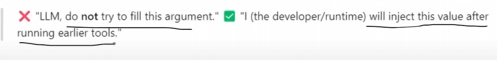

In [128]:
import json
for tool_call in ai_message.tool_calls:
    # execute the 1st tool and get the value of conversion rate
    # execute the 2nd tool using the conversion rate from tool 1
    if tool_call['name']=='get_conversion_factor':
        tool_message1=get_conversion_factor.invoke(tool_call)
        print(tool_message1)
        print(tool_call)
    # fetch this conversion rate
        print(json.loads(tool_message1.content)['conversion_rate'])
        messages.append(tool_message1)

content='{"result": "success", "documentation": "https://www.exchangerate-api.com/docs", "terms_of_use": "https://www.exchangerate-api.com/terms", "time_last_update_unix": 1754697601, "time_last_update_utc": "Sat, 09 Aug 2025 00:00:01 +0000", "time_next_update_unix": 1754784001, "time_next_update_utc": "Sun, 10 Aug 2025 00:00:01 +0000", "base_code": "USD", "target_code": "INR", "conversion_rate": 87.6122}' name='get_conversion_factor' tool_call_id='5d0ef7be-f590-4045-a2b8-a6cc8cee90a4'
{'name': 'get_conversion_factor', 'args': {'target_currency': 'INR', 'base_currency': 'USD'}, 'id': '5d0ef7be-f590-4045-a2b8-a6cc8cee90a4', 'type': 'tool_call'}
87.6122
